# Proyecto 04 - Informe Final Carrera - Series de Tiempo - Franco Terenti

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

En este proyecto tomaremos el proyecto 3 pero utilizando 10 años en vez de los 3 utilizados originalmente y se buscara trabajar con un modelo de redes neuronales para compararlo con los utilizados anteriormente.

Para el siguiente proyecto se utilizaron los datasets de los ultimos 10 años, que podran se descargados de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar los años 2010 a 2020. Inicialmente se utilizara hasta 2019 y luego agregaremos el 2020 para analizar el funcionamiento de nuestro modelo en un año atipico como el 2020

### Parte A - Exploración de Datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Parte B - Modelo de Machine Learning

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Parte C - Nuevos Modelos
Para esta parte se utilizara un modelo regresor de perceptrón multicapa. El perceptrón multicapa es una red neuronal artificial (RNA) formada por múltiples capas, de tal manera que tiene capacidad para resolver problemas que no son linealmente separables. El perceptrón multicapa puede estar totalmente o localmente conectado. En el primer caso cada salida de una neurona de la capa "i" es entrada de todas las neuronas de la capa "i+1", mientras que en el segundo cada neurona de la capa "i" es entrada de una serie de neuronas (región) de la capa "i+1".




# Parte A - Exploración de Datos

In [1]:
# Importamos todas las librerias que utilizaremos a lo largo del proyecto

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import shap
from pycaret.regression import *
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.neural_network import MLPRegressor 

In [2]:
# EXTRA FORMATO TEXTO
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [3]:
# Leemos los datos de los ultimos 10 anios
data_2019 = pd.read_csv('Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets/flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('Datasets/flujo-vehicular-2016.csv', sep =',')
data_2015 = pd.read_csv('Datasets/flujo-vehicular-2015.csv', sep =',')
data_2014 = pd.read_csv('Datasets/flujo-vehicular-2014.csv', sep =',')
data_2013 = pd.read_csv('Datasets/flujo-vehicular-2013.csv', sep =',')
data_2012 = pd.read_csv('Datasets/flujo-vehicular-2012.csv', sep =',')
data_2011 = pd.read_csv('Datasets/flujo-vehicular-2011.csv', sep =',')
data_2010 = pd.read_csv('Datasets/flujo-vehicular-2010.csv', sep =',')

In [4]:
# Vemos columnas del dataset del 2019, si existen valores nulos, su tipo de dato, y las primeras filas
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [5]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())
print(data_2016['estacion'].unique())
print(data_2015['estacion'].unique())
print(data_2014['estacion'].unique())
print(data_2013['estacion'].unique())
print(data_2012['estacion'].unique())
print(data_2011['estacion'].unique())
print(data_2010['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia' 'Retiro' 'Sarmiento'
 'Dellepiane Centro' 'Salguero']
['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia' 'Retiro' 'Sarmiento'
 nan]
['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia']
['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia']
['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia']
['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia']


In [6]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())
print(data_2016['sentido'].unique())
# print(data_2015['sentido'].unique())
# print(data_2014['sentido'].unique())
# print(data_2013['sentido'].unique())
# print(data_2012['sentido'].unique())
# print(data_2011['sentido'].unique())
# print(data_2010['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [7]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())
print(data_2016['tipo_vehiculo'].unique())
print(data_2015['tipo_vehiculo'].unique())
print(data_2014['tipo_vehiculo'].unique())
print(data_2013['tipo_vehiculo'].unique())
print(data_2012['tipo_vehiculo'].unique())
print(data_2011['tipo_vehiculo'].unique())
print(data_2010['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado' nan]
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado' nan]


In [8]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())
print(data_2016['forma_pago'].unique())
print(data_2015['forma_pago'].unique())
print(data_2014['forma_pago'].unique())
print(data_2013['forma_pago'].unique())
print(data_2012['forma_pago'].unique())
print(data_2011['forma_pago'].unique())
print(data_2010['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']
['NO COBRADO' 'EFECTIVO' 'EXENTO' 'AUPASS' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']
['NO COBRADO' 'EFECTIVO' 'AUPASS' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO' nan]
['NO COBRADO' 'EFECTIVO' 'AUPASS' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'MONEDERO' 'INFRACCION']
['NO COBRADO' 'EFECTIVO' 'EXENTO' 'AUPASS' 'TARJETA DISCAPACIDAD'
 'MONEDERO' 'INFRACCION']
['NO COBRADO' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD' 'AUPASS'
 'MONEDERO' 'INFRACCION']
['EFECTIVO' 'EXENTO' 'AUPASS' 'TARJETA DISCAPACIDAD' 'MONEDERO'
 'NO COBRADO' 'INFRACCION']


##### Podemos decir entonces que los años **2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018 y 2019** tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [9]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017, data_2016, data_2015, data_2014, data_2013, data_2012, data_2011, data_2010])


#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset_efectivo = dataset[mask]

# Hacemos un cruce de informacion por la diferencia entre diferentes anios
dataset_efectivo.hora.fillna(dataset_efectivo.hora_inicio, inplace=True)

#Quitamos las columnas que no vamos a utilizar
dataset_efectivo.drop(columns = ['periodo','hora_fin','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset_efectivo.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,fecha,dia,sentido,tipo_vehiculo,cantidad_pasos,hora
80,2019-01-01,Martes,Centro,Liviano,537.0,1.0
86,2019-01-01,Martes,Centro,Pesado,1.0,1.0
88,2019-01-01,Martes,Provincia,Liviano,443.0,1.0
94,2019-01-01,Martes,Provincia,Pesado,1.0,1.0
149,2019-01-01,Martes,Centro,Liviano,769.0,2.0


In [10]:
# Vemos un resumen del nuevo datatset completo
dataset_efectivo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705782 entries, 80 to 618666
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fecha           705782 non-null  object 
 1   dia             705782 non-null  object 
 2   sentido         346566 non-null  object 
 3   tipo_vehiculo   705782 non-null  object 
 4   cantidad_pasos  705782 non-null  float64
 5   hora            705782 non-null  float64
dtypes: float64(2), object(4)
memory usage: 37.7+ MB


In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_efectivo['fecha2'] = pd.to_datetime(dataset_efectivo.fecha) + pd.to_timedelta(dataset_efectivo.hora, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_efectivo.drop(columns=['fecha','hora'], inplace = True)

dataset_efectivo.head()
dataset_efectivo


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537.0,2019-01-01 01:00:00
86,Martes,Centro,Pesado,1.0,2019-01-01 01:00:00
88,Martes,Provincia,Liviano,443.0,2019-01-01 01:00:00
94,Martes,Provincia,Pesado,1.0,2019-01-01 01:00:00
149,Martes,Centro,Liviano,769.0,2019-01-01 02:00:00
...,...,...,...,...,...
618656,Viernes,NaN,Pesado,1.0,2010-12-31 22:00:00
618657,Viernes,NaN,Pesado,2.0,2010-12-31 22:00:00
618659,Viernes,NaN,Liviano,1.0,2010-12-31 23:00:00
618661,Viernes,NaN,Liviano,73.0,2010-12-31 23:00:00


In [12]:
#Corregimos el nombre de fecha2 a fecha
dataset_efectivo.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_efectivo.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537.0,2019-01-01 01:00:00
86,Martes,Centro,Pesado,1.0,2019-01-01 01:00:00
88,Martes,Provincia,Liviano,443.0,2019-01-01 01:00:00
94,Martes,Provincia,Pesado,1.0,2019-01-01 01:00:00
149,Martes,Centro,Liviano,769.0,2019-01-01 02:00:00


In [13]:
#Reordenamos el dataset_efectivo por fecha
dataset_efectivo.sort_values('fecha', inplace = True)
dataset_efectivo.reset_index(drop=True, inplace = True)
dataset_efectivo


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Viernes,NaN,Liviano,189.0,2010-01-01 00:00:00
1,Viernes,NaN,Liviano,3.0,2010-01-01 00:00:00
2,Viernes,NaN,Pesado,1.0,2010-01-01 00:00:00
3,Viernes,NaN,Pesado,1.0,2010-01-01 01:00:00
4,Viernes,NaN,Liviano,13.0,2010-01-01 01:00:00
...,...,...,...,...,...
705777,Martes,Provincia,Liviano,556.0,2019-12-31 21:00:00
705778,Martes,Centro,Pesado,2.0,2019-12-31 21:00:00
705779,Martes,Centro,Liviano,214.0,2019-12-31 22:00:00
705780,Martes,Provincia,Liviano,190.0,2019-12-31 22:00:00


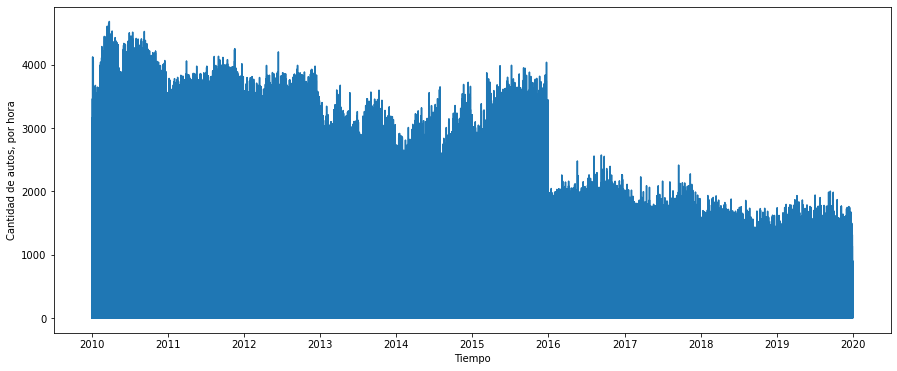

In [14]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset_efectivo.fecha, dataset_efectivo.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

Flujo de automoviles por hora a lo largo de 10 años

Resampleamos nuestros datos para agrupar por dia, lograr una visualización mas comoda y convertir los datos a los requerimientos de nuestro problema (trafico diario)

In [15]:
diario = dataset_efectivo.resample('D', on = 'fecha').sum()
print(diario.shape)

(3652, 1)


Pasamos los valores menores a 10000 que se pueden considerar outliers a nan para luegos interpolarlos y completarlos

In [16]:
diario.cantidad_pasos[diario.cantidad_pasos < 10000] = np.nan
diario = diario.interpolate()
diario.head()

,cantidad_pasos
fecha,
2010-01-01,21123.0
2010-01-02,31115.0
2010-01-03,34024.0
2010-01-04,51844.0
2010-01-05,54809.0


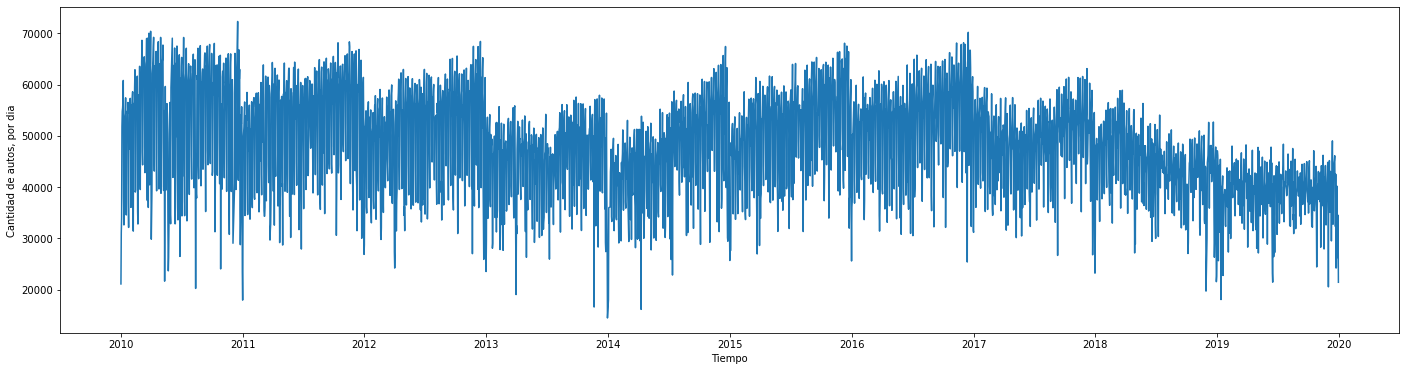

In [17]:
plt.figure(figsize = (24,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Flujo de automoviles por dia a lo largo de 10 años

### Autocorrelacion

In [18]:
# nlags =  52
# autocorr = acf(dataset_efectivo.cantidad_pasos, nlags = nlags)

# autocorr.shape
# plt.figure(figsize = (8,5))
# plt.scatter(np.arange(nlags+1), autocorr)
# plt.xlabel('lag')

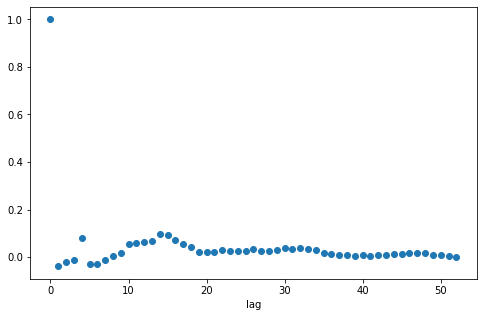

En este caso no vemos una autocorrelacion significativa

In [19]:
# plot_acf(diario.cantidad_pasos, lags = 50)
# plt.show()

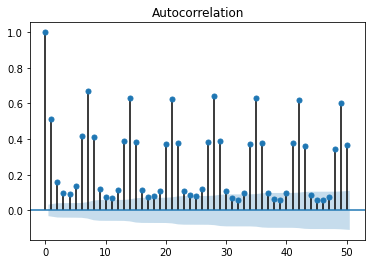

En este caso vemos una autocorrelacion muy significativa con un ciclo semanal, esto nos dice que el mismo dia semanal de la semana anterior tiene importancia a la hora de predecir ese dia. Por ejemplo si queremos saber como va a ser el trafico el proximo Lunes, los Lunes anteriores van a ser importantes para nuestro modelos

In [20]:
# Verifico que este completo
diario_check = diario.copy()
diario_check.reset_index(inplace=True)
diario_check['data_check']=diario_check.fecha.diff()
diario_check['data_check'].value_counts()

1 days    3651
Name: data_check, dtype: int64

Verificamos que todos los datos sean equidistante en fechas entre si, y efectivamente vemos que en todos existe una diferencia de un dia, por ende no tenemos valores faltantes

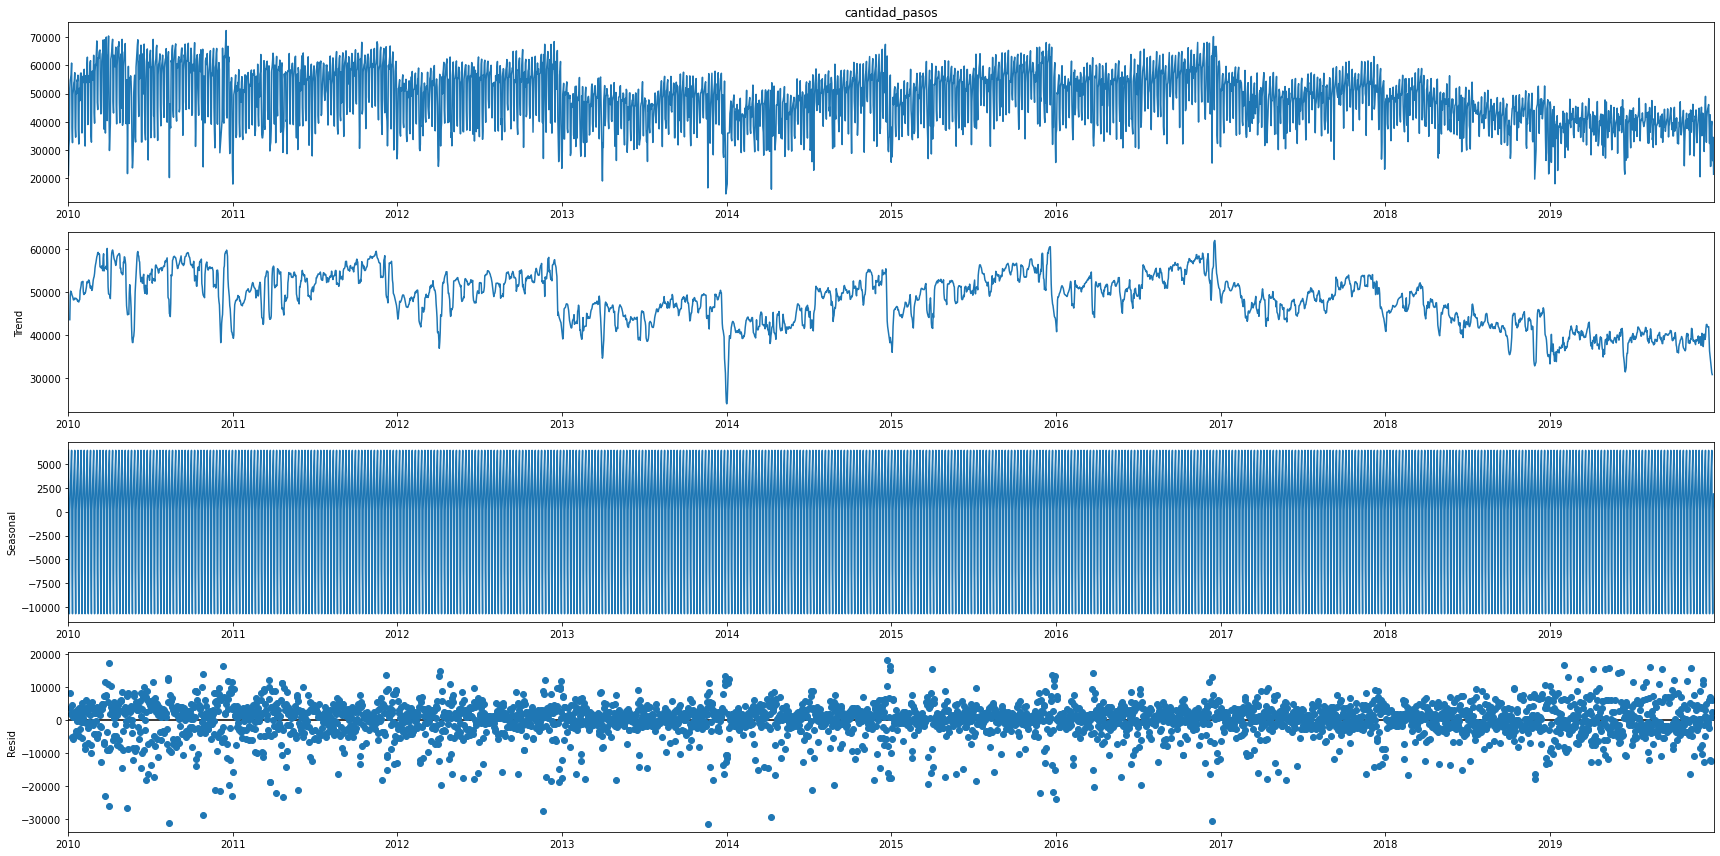

In [21]:
result = seasonal_decompose(diario.cantidad_pasos, model='aditive')
plt.rcParams['figure.figsize'] = [24,12]
result.plot()
plt.show()


Descomponemos nuestra serie y descubrimos informacion interesante como que tiene una tendecia negativa, que todos los anos cumplen un ciclo de tendecia similar, luego vemos que la estacionalidad de la serie es semanal y que tenemos un ruido disperso que nos indica que no sucede nada raro

### Componentes de la serie ¿puede ser porque se migre a otras formas de pago?

Para esto analizaremos efectivo con telepase. Lo primero que haremos sera aplicar los mismos filtros aplicados anteriormente pero con telepase para luego compararlos

In [22]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', np.logical_or(dataset.forma_pago == 'TELEPASE', dataset.forma_pago == 'AUPASS'))
dataset_telepase = dataset[mask]

dataset_telepase.hora.fillna(dataset_telepase.hora_inicio, inplace=True)

#Quitamos las columnas que no vamos a utilizar
dataset_telepase.drop(columns = ['periodo','hora_fin','hora_inicio','forma_pago', 'estacion'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_telepase['fecha2'] = pd.to_datetime(dataset_telepase.fecha) + pd.to_timedelta(dataset_telepase.hora, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_telepase.drop(columns=['fecha','hora'], inplace = True)
dataset_telepase.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_telepase.sort_values('fecha', inplace = True)
dataset_telepase.reset_index(drop=True, inplace = True)
diario_telepase = dataset_telepase.resample('D', on = 'fecha').sum()
diario_telepase.cantidad_pasos[diario_telepase.cantidad_pasos < 10000] = np.nan
diario_telepase = diario_telepase.interpolate()
diario_telepase.dropna(inplace=True)
result_telepase = seasonal_decompose(diario_telepase.cantidad_pasos, model='aditive')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [23]:
# Verifico que este completo
diario_check_telepase = diario_telepase.copy()
diario_check_telepase.reset_index(inplace=True)
diario_check_telepase['data_check']=diario_check_telepase.fecha.diff()
diario_check_telepase['data_check'].value_counts()

1 days    3648
Name: data_check, dtype: int64

Verificamos que todos los datos sean equidistante en fechas entre si, y efectivamente vemos que en todos existe una diferencia de un dia, por ende no tenemos valores faltantes

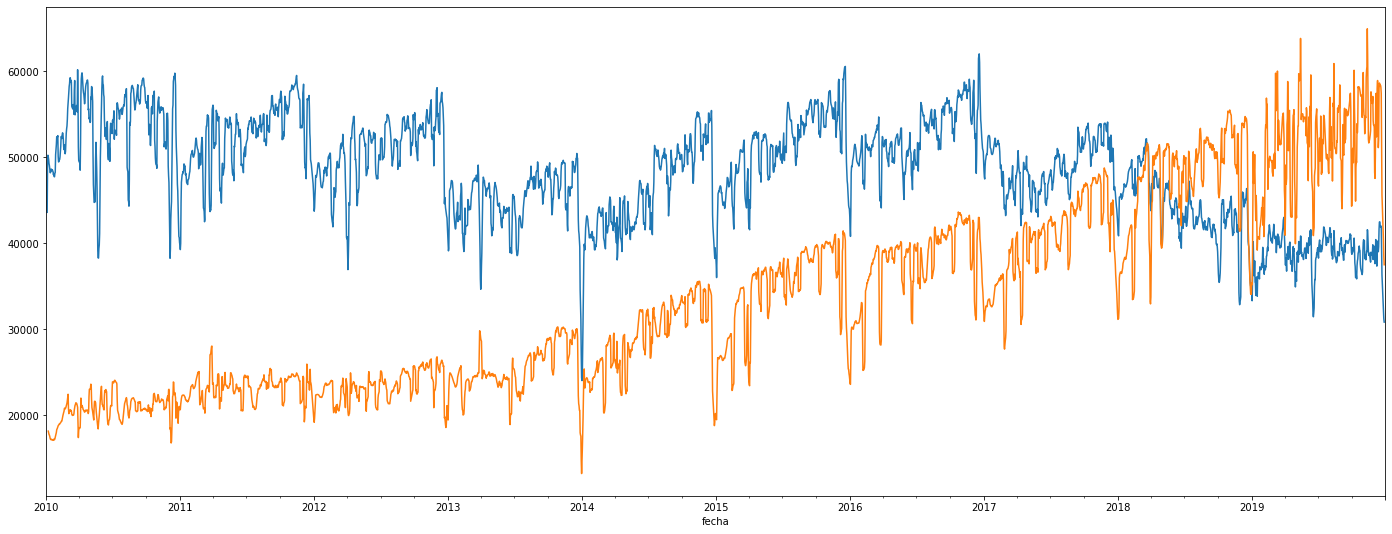

In [24]:
plt.rcParams['figure.figsize'] = [24,9]
result.trend.plot()
result_telepase.trend.plot()
plt.show()

Analizamos la tendencia de ambos resultados y podemos ver como efectivamente existe una correlacion inversa clara, al menos graficamente hablando, esto de alguna manera vuelve valida nuestra hipotesos.

In [25]:
diario.corrwith(diario_telepase)

cantidad_pasos    0.250568
dtype: float64

Por ultimo analizamos esta correlacion de manera analitica, y podemos ver que existe una correlacion aunque su valor no es muy alto

# Parte B - Modelo de Machine Learning

In [26]:
def evaluate(test_features, test_labels,predictions):
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print(' ')
    print('Error Promedio: {:0.4f} dias.'.format(np.mean(errors)))
    print('Exactitud = {:0.2f}%.'.format(accuracy))
    
    return accuracy


# Defino funcion para evaluar de manera comoda
def evaluar_valores(model_,x_,y_, X_train_, X_test_, y_train_, y_test_,y_train_pred_, y_test_pred_):
        
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train_, y_train_pred_))
    rmse_test = np.sqrt(mean_squared_error(y_test_, y_test_pred_))
    
    mae_train = mean_absolute_error(y_train_, y_train_pred_)
    mae_test = mean_absolute_error(y_test_, y_test_pred_)

    r2_train = r2_score(y_train_, y_train_pred_)
    r2_test = r2_score(y_test_, y_test_pred_)
    
    print('')
    print(f'Error en Train: {rmse_train}')
    print(f'Error en Test: {rmse_test}')
    print('')
#     print('')
#     print(color.BOLD + f'Raíz del error cuadrático medio(RMSE) en Train: {rmse_train}',color.END)
#     print(color.BOLD + f'Raíz del error cuadrático medio(RMSE) en Test: {rmse_test}',color.END)
#     print('')

#     print(f'Error absoluto medio (MAE) en Train: {mae_train}')
#     print(f'Error absoluto medio (MAE) en Test: {mae_test}')
    
#     print(f'R² en Train: {r2_train}')
#     print(f'R² en Test: {r2_test}')
    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train_ - y_train_pred_, bins = 20, label = 'train')
    sns.distplot(y_test_ - y_test_pred_, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test_,y_test_pred_, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()


# Defino funcion para evaluar de manera comoda
def evaluar_valores_pred(x_,y_, X_train_, X_test_, y_train_, y_test_, y_test_pred_):
    
    ### CALCULAMOS EL ERROR
    rmse_test = np.sqrt(mean_squared_error(y_test_, y_test_pred_))
       
    print('')
    print(f'Error: {rmse_test}')
    print('')
    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_test_ - y_test_pred_, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test_,y_test_pred_, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

## Test de Dickey-Fuller
La serie es estacionaria si p es menor a 0.05

In [27]:
# Test de Dickey-Fuller  
result = adfuller(diario.cantidad_pasos)
print('ADF Statistic: %f' % result[0])
print(color.BOLD + 'p-value: %f' % result[1]+color.END)
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.783783
p-value: 0.060628
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


El valor que debemos tener en cuenta es "p-value”. Siempre queremos que el valor de p sea menor a 0.05 por lo tanto se rechaza la hipotesis nula, y podemos decir que la serie no es estacionaria. De todas formas al estar cerca al valor maximo para que sea estacionaria se podria probar los modelos clasicos como ARIMA y ARMA los cuales son modelos parametricos.

## One-Step Prediction

In [28]:
senial = diario.cantidad_pasos
senial.head()

fecha
2010-01-01    21123.0
2010-01-02    31115.0
2010-01-03    34024.0
2010-01-04    51844.0
2010-01-05    54809.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [29]:
look_back = 180 # usamos 6 meses de datos para predecir el valor siguiente

In [30]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(3471, 180) (3471,)


In [31]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [32]:
N_train = 365*8 - look_back # cantidad de instancias que vamos a usar para entrenar. (8 anios)
N_test = 365*2 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(2740, 180) (2740,)
(730, 180) (730,)


In [33]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

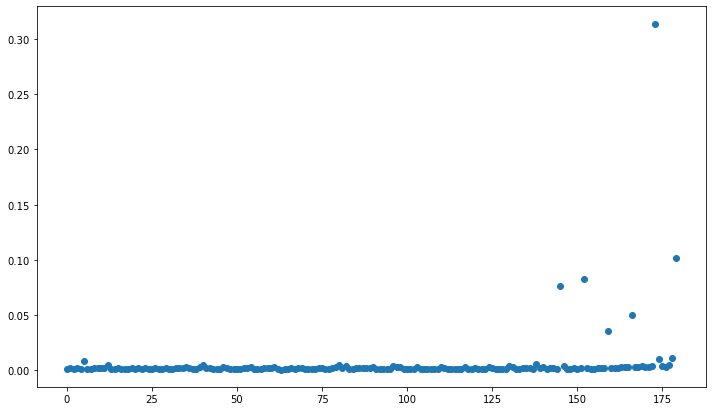

In [34]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
# for x in np.arange(7)*30:
#     plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

In [35]:
# shap_values = shap.TreeExplainer(rf).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")


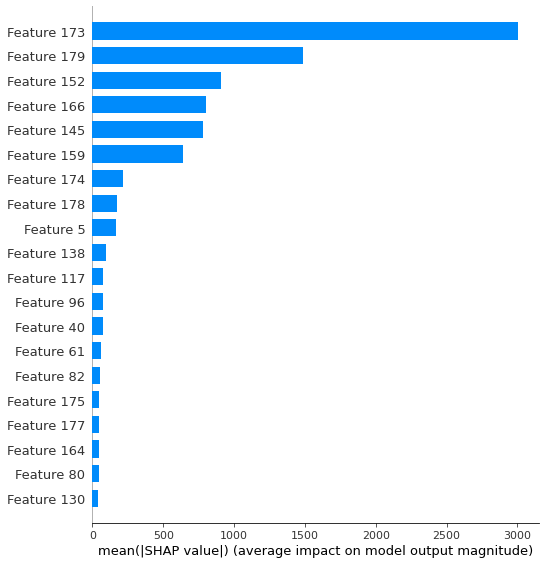

In [36]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

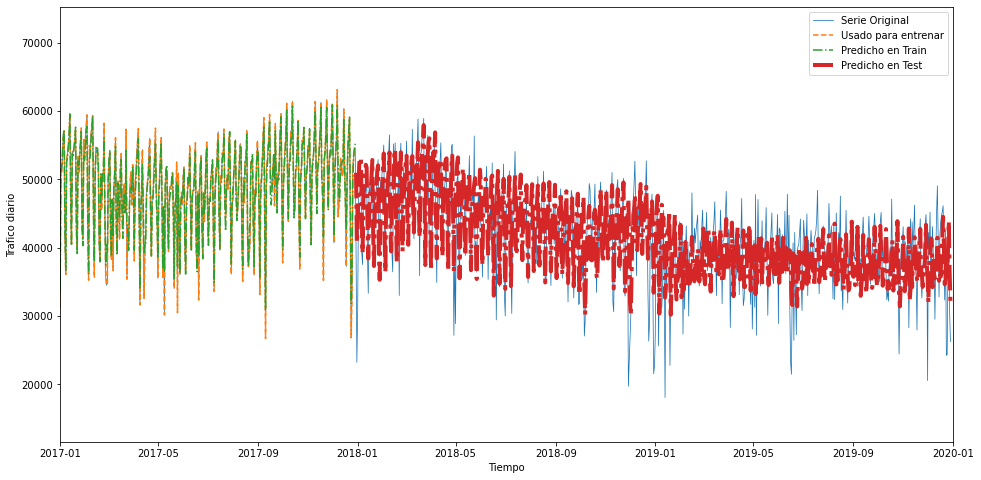

In [37]:
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Trafico diario')

ax.set_xlim([datetime.datetime.strptime('2017', '%Y')],datetime.datetime.strptime('2020', '%Y'))

plt.show()


Error en Train: 2212.961185655224
Error en Test: 5072.156445736468



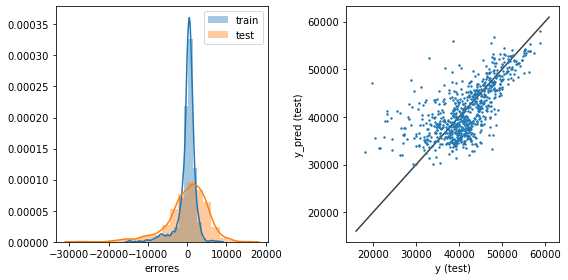

 
Error Promedio: 3790.0639 dias.
Exactitud = 89.77%.


In [38]:
evaluar_valores(rf, X,y, X_train, X_test, y_train, y_test,y_train_pred,y_test_pred)
base_accuracy = evaluate(X_test, y_test,y_test_pred)


## Benchmark

In [39]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

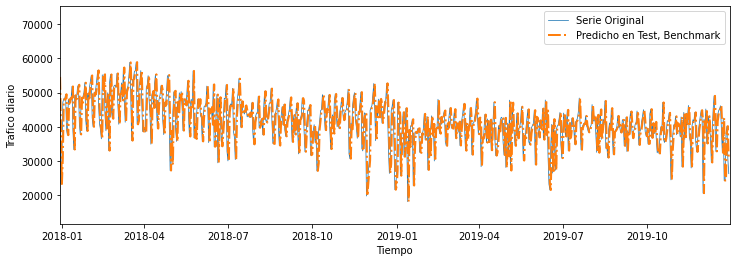

In [40]:
plt.figure(figsize=(12,4))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial.index[N_train+look_back], senial.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Trafico diario')
plt.legend()
plt.show()


Error: 6821.763619184368



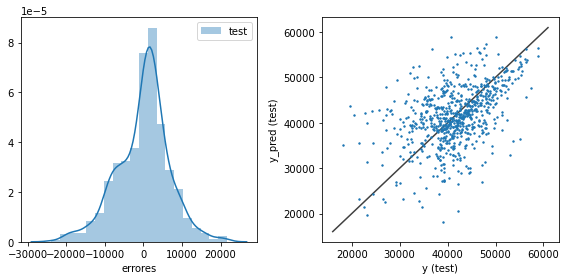

 
Error Promedio: 5148.9822 dias.
Exactitud = 86.51%.


In [41]:
evaluar_valores_pred(X,y, X_train, X_test, y_train, y_test,y_test_pred_benchmark)
accuracy_benchmark = evaluate(X_test, y_test,y_test_pred_benchmark)

## Multi-Step Prediction


In [42]:
y_ms_test_pred = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred = rf.predict(x.reshape(1,-1))
    y_ms_test_pred.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred = np.array(y_ms_test_pred)

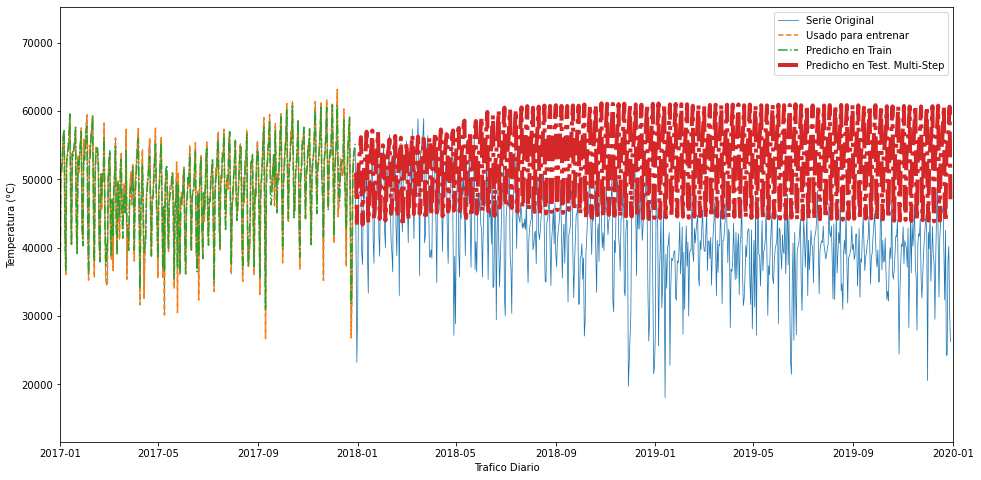

In [43]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_ms_test_pred,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
ax.set_xlim([datetime.datetime.strptime('2017', '%Y')],datetime.datetime.strptime('2020', '%Y'))

plt.legend()
plt.xlabel('Trafico Diario')
plt.ylabel('Temperatura (°C)')


plt.show()


Error en Train: 2212.961185655224
Error en Test: 13838.893671357706



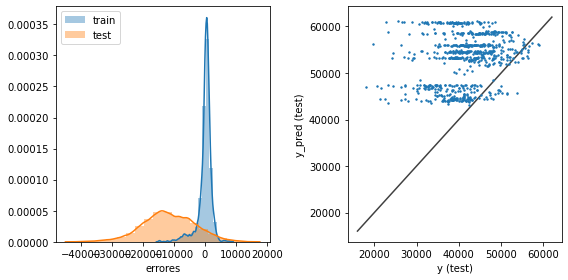

 
Error Promedio: 12272.0470 dias.
Exactitud = 66.94%.


In [44]:
evaluar_valores(rf, X,y, X_train, X_test, y_train, y_test,y_train_pred,y_ms_test_pred)
accuracy_ms_ = evaluate(X_test, y_test,y_ms_test_pred)


## Busqueda de mejores modelos - PyCaret

In [45]:
# data_pycaret = pd.DataFrame(X_train).reset_index(drop=True)
# data_pycaret['Y'] = pd.DataFrame(y_train).reset_index(drop=True)
# reg1 = setup(data_pycaret, target = 'Y', session_id=123, silent=True,verbose=False)
# best_std = compare_models(fold = 5, sort = 'RMSE', turbo = True)

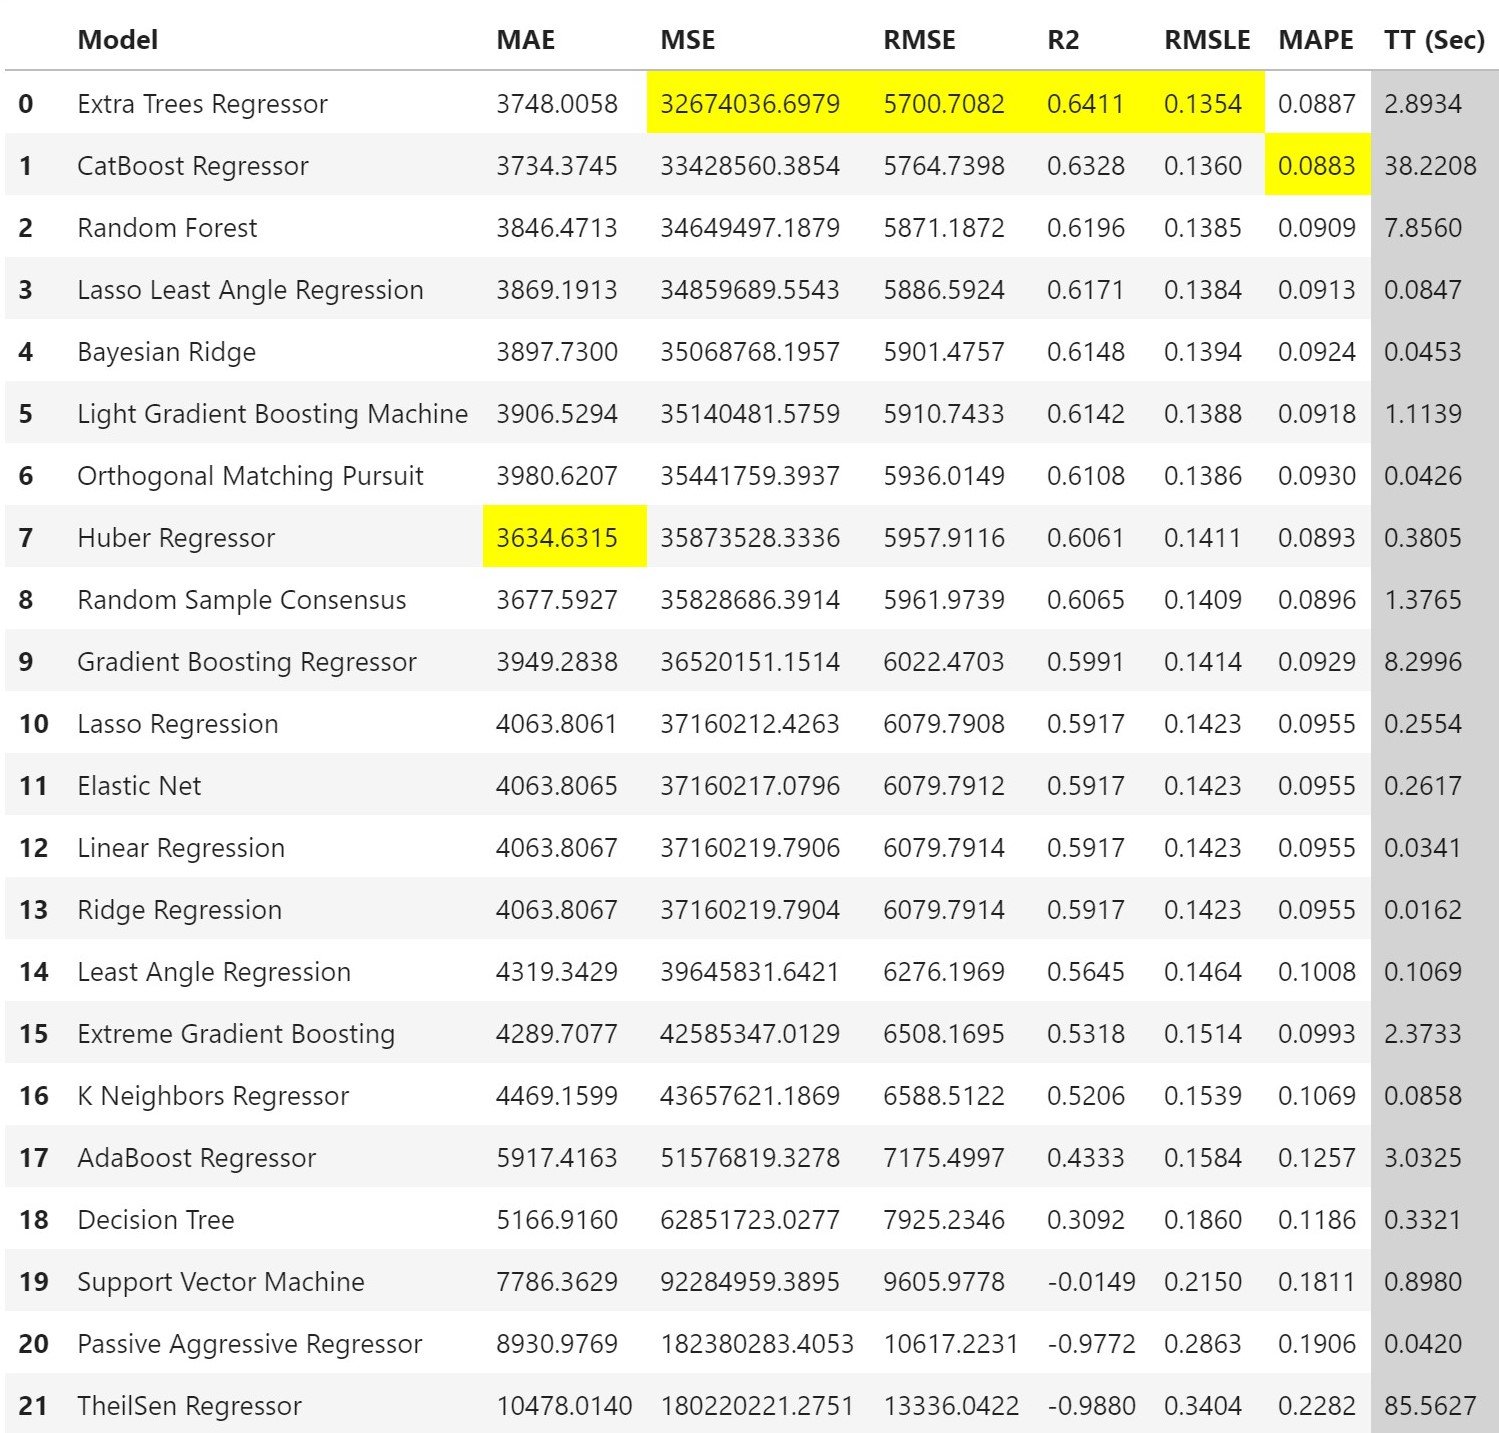

Podemos ver que entre nuestro conocido Random Forest y otros modelos mejores no hay mucha diferencia por ende seguiremos trabajando con el mismo modelo ya que es de facil interpretacion

## Optimizacion de hiperparametros

### Grid Search 

In [46]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'n_estimators': [10,20,30,40,50, 100, 200, 300, 1000]
}
# Create a based model
# rf = RandomForestRegressor()
# Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)
# Fit the grid search to the data
# grid_search.fit(X_train,y_train)

# grid_search.best_params_

{'max_depth': 90, 'n_estimators': 1000}

### Evaluacion Grid Search

In [47]:
# rf_grid_search = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs = 4, max_depth=90).fit(X_train,y_train)

In [48]:
# y_train_pred_gs = rf_grid_search.predict(X_train)
# y_test_pred_gs = rf_grid_search.predict(X_test)

In [49]:
# fig, ax = plt.subplots(figsize=(16,8))

# plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
# plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
# plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_gs,'-.',label = 'Predicho en Train')
# plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_gs,'-.', lw = 4, label = 'Predicho en Test')
# plt.legend()
# plt.xlabel('Tiempo')
# plt.ylabel('Trafico diario')

# ax.set_xlim([datetime.datetime.strptime('2017', '%Y')],datetime.datetime.strptime('2020', '%Y'))

# plt.show()

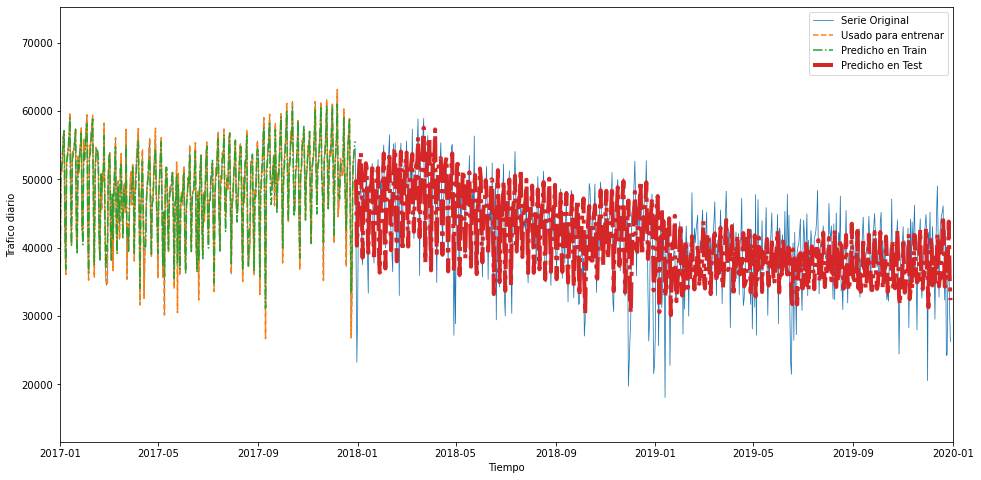

In [50]:
# evaluar_valores(rf_grid_search, X,y, X_train, X_test, y_train, y_test,y_train_pred_gs,y_test_pred_gs)
# grid_accuracy = evaluate(X_test, y_test,y_test_pred_gs)


Error en Train: 2127.011521446948  
Error en Test: 5057.775943487097  
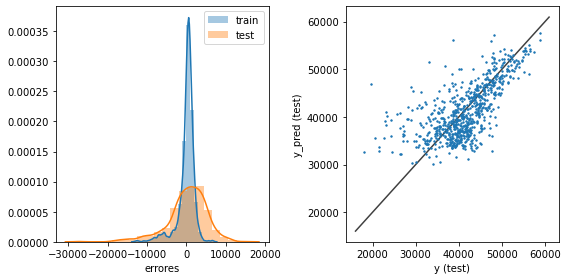  
Error Promedio: 3768.0064 dias.  
Exactitud = 89.86%.  

In [51]:
# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.10%.

In [52]:
# 2020 agregar

## Analisis en 2020

In [53]:
data_2020 = pd.read_csv('Datasets/flujo-vehicular-2020.csv', sep =',')

In [54]:
data_2020.info()
data_2020.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628081 entries, 0 to 1628080
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1628081 non-null  int64 
 1   fecha           1628081 non-null  object
 2   mes             1628081 non-null  object
 3   dia             1628081 non-null  object
 4   dia_fecha       1628081 non-null  int64 
 5   hora_inicio     1628081 non-null  int64 
 6   hora_fin        1628081 non-null  int64 
 7   estacion        1628081 non-null  object
 8   tipo_vehiculo   1628081 non-null  object
 9   forma_pago      1628081 non-null  object
 10  observacion     1628081 non-null  object
 11  sentido         1628081 non-null  object
 12  cantidad_pasos  1628081 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 161.5+ MB


,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Centro,24
1,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80
2,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1
3,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1
4,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1


In [55]:
print(data_2020['forma_pago'].unique())


['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']


In [56]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask_2020 = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
dataset_2020 = data_2020[mask_2020]

dataset_2020["hora"] = np.nan
dataset_2020.hora.fillna(dataset_2020.hora_inicio, inplace=True)

#Quitamos las columnas que no vamos a utilizar
dataset_2020.drop(columns = ['periodo','hora_fin','hora_inicio','forma_pago', 'estacion','dia_fecha'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_2020['fecha2'] = pd.to_datetime(dataset_2020.fecha) + pd.to_timedelta(dataset_2020.hora, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_2020.drop(columns=['fecha','hora'], inplace = True)
dataset_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_2020.sort_values('fecha', inplace = True)
dataset_2020.reset_index(drop=True, inplace = True)
diario_2020 = dataset_2020.resample('D', on = 'fecha').sum()
diario_2020.cantidad_pasos[diario_2020.cantidad_pasos < 10000] = np.nan
diario_2020 = diario_2020.interpolate()
diario_2020.dropna(inplace=True)
diario_2020_seasonal = seasonal_decompose(diario_2020.cantidad_pasos, model='aditive')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

In [57]:
diario_2020.head()

,cantidad_pasos
fecha,
2020-01-01,21395.0
2020-01-02,33722.0
2020-01-03,37067.0
2020-01-04,30627.0
2020-01-05,27812.0


In [58]:
senial_2020 = diario_2020.cantidad_pasos
(senial_2020.shape)
senial_2020.head()

fecha
2020-01-01    21395.0
2020-01-02    33722.0
2020-01-03    37067.0
2020-01-04    30627.0
2020-01-05    27812.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [59]:
senial_total = pd.concat([senial,senial_2020])

In [60]:
N_total = senial_total.shape[0]
X_total = np.zeros((N_total - look_back - 1,look_back))
y_total = np.zeros(N_total - look_back - 1)
# print(X_total.shape, y_total.shape)



for i in range(X_total.shape[0]):
    X_total[i,:] = senial_total.iloc[i:i+look_back]
    y_total[i] = senial_total.iloc[i+look_back]



N_train_total = 365*10 - look_back # cantidad de instancias que vamos a usar para entrenar. (8 anios)
N_test_total = 245 # igual a la cantidad de datos en 2020
N_total_total = N_train_total + N_test_total

length_total_total = N_train_total + N_test_total + look_back

X_train_total = X_total[:N_train_total,:]
y_train_total = y_total[:N_train_total]

X_test_total = X_total[N_train_total:N_train_total+N_test_total,:]
y_test_total = y_total[N_train_total:N_train_total+N_test_total]



y_pred_total = rf.predict(X_total)
y_train_pred_total = rf.predict(X_train_total)
y_test_pred_total = rf.predict(X_test_total)
y_2020 = rf.predict(X_test_total)

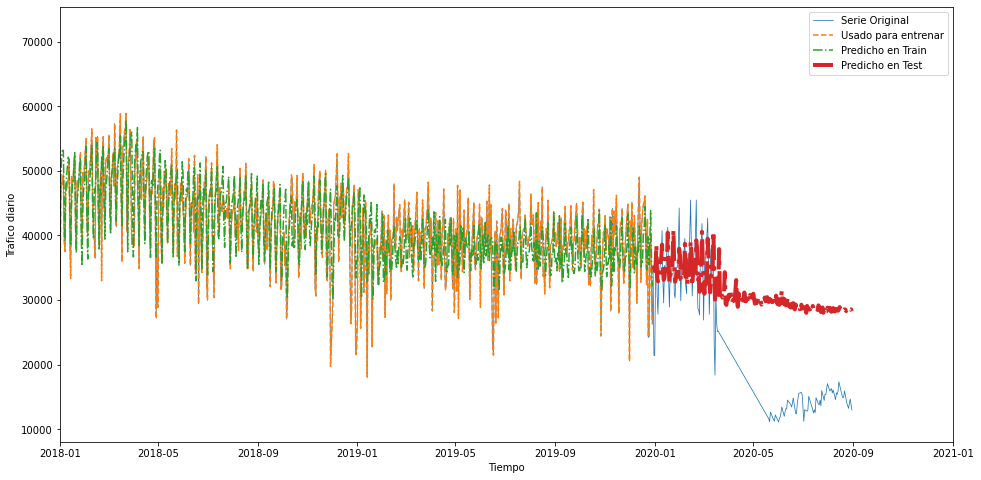

In [61]:
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(senial_total.index[:length_total_total], senial_total[:length_total_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial_total.index[:N_train_total + look_back], senial_total[:N_train_total + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial_total.index[look_back: look_back + N_train_total], y_train_pred_total,'-.',label = 'Predicho en Train')
plt.plot(senial_total.index[N_train_total+look_back: length_total_total], y_test_pred_total,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Trafico diario')

ax.set_xlim([datetime.datetime.strptime('2018', '%Y')],datetime.datetime.strptime('2021', '%Y'))

plt.show()


Error en Train: 2212.961185655224
Error en Test: 11844.418014576022



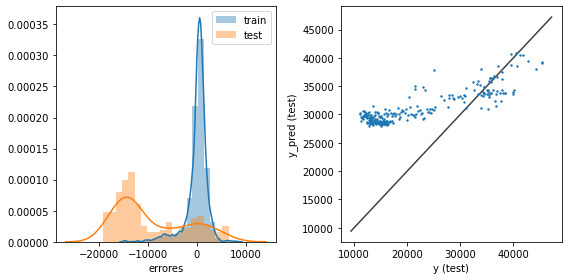

 
Error Promedio: 10313.3190 dias.
Exactitud = 32.55%.


In [62]:
evaluar_valores(rf, X,y, X_train, X_test_total, y_train, y_test_total,y_train_pred,y_2020)
accuracy_2020 = evaluate(X_test_total, y_test_total,y_2020)

Como era de esperar se puede ver que el modelo es muy malo a la hora de predecir valores de trafico para el 2020

# Parte C - Nuevos Modelos
## Redes - Multi-layer Perceptron regressor

In [63]:
regr_MLP = MLPRegressor(random_state=42, max_iter=2000).fit(X_train, y_train)

In [64]:
y_pred_MLP = regr_MLP.predict(X)
y_train_pred_MLP = regr_MLP.predict(X_train)
y_test_pred_MLP = regr_MLP.predict(X_test)

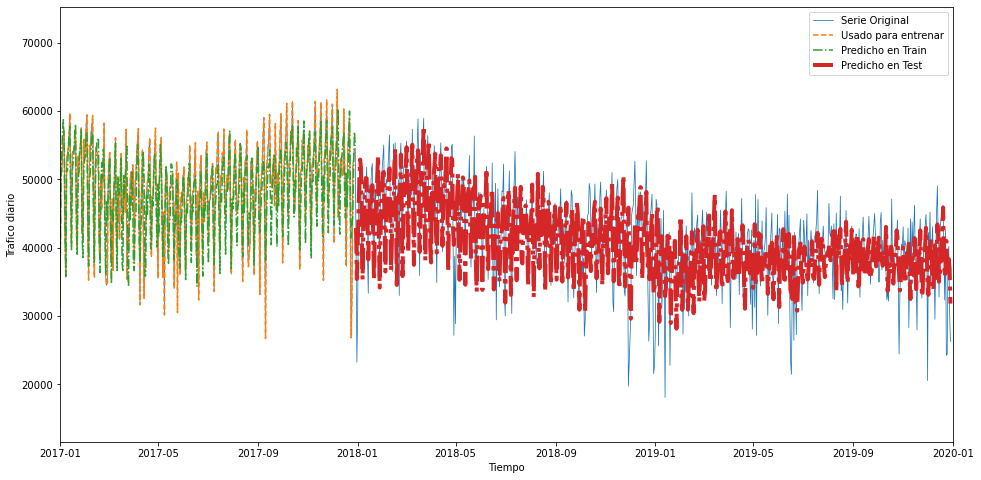

In [65]:
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(senial.index[:length_total], senial[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred_MLP,'-.',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred_MLP,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Trafico diario')

ax.set_xlim([datetime.datetime.strptime('2017', '%Y')],datetime.datetime.strptime('2020', '%Y'))

plt.show()


Error en Train: 5728.4287786988925
Error en Test: 4906.90206401399



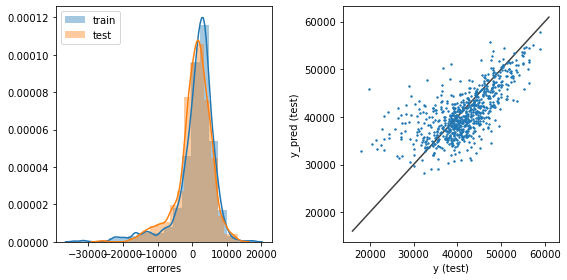

 
Error Promedio: 3663.7986 dias.
Exactitud = 90.25%.


In [66]:
evaluar_valores(rf, X,y, X_train, X_test, y_train, y_test,y_train_pred_MLP,y_test_pred_MLP)
base_accuracy = evaluate(X_test, y_test,y_test_pred_MLP)


En este caso al usar un modelo de tipo perceptrón multicapa, podemos ver como la distribucion de errores tanto en el test como el train es muy similar, ha mejorado un poco la exactitud, aunque seguimos viendo muchos valores alejados o outliers.

# Conclusion
Como conclusion podemos decir que hasta ahora los modelos observados (incluso una red neuronal muy basica) no son buenos predictores. Se observa tambien que el agregar mas años mejora en medida las predicciones pero vemos tambien como introducen errores en el caso de outliers y valores atipicos. Al tomar los datos en periodos mas grandes como pueden ser mensuales o anuales vimos una mejora notablemente ya que disminuimos la variabilidad de los fatos. En el caso del año 2020 vimos que la prediccion se aleja muchisimo de la realidad, esto nos deja en evidencia, como variables externas como la pandemia. Por ultimo debido a la pandemia se vio forzada la migracion definitiva a telepase, esto debido al riesgo que implicaba el pago en efecto, por esto podriamos plantear que al combinar ambos tipos de pagos, podria disminuir la variacion y por ende mejorar la prediccion.